In [1]:
import os
import nibabel as nib
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
# setting the working folder to the following path
data_path = 'C:\\Users\\romai\\OneDrive\\Bureau\\Erasmus\\Deep_Learning\\test'
os.chdir(r'C:\\Users\\romai\\OneDrive\\Bureau\\Erasmus\\Deep_Learning\\test')

os.listdir() # function that returns files in a folder

['Patient 383',
 'Patient 384',
 'Patient 410',
 'Patient 416',
 'Patient 430',
 'Patient 513',
 'Patient 531',
 'Patient 634',
 'Patient 836']

I am in the folder Patient 383
Unexpected file! 13_epi_diffusion_petit_fov_b_100-600_adc.nii.gz
Unexpected file! cg_mask.nii.gz
Unexpected file! epi_diffusion_petit_fov_b_100-600.nii.gz
Unexpected file! pz_mask.nii.gz
Unexpected file! t1_vibe_fs_tra_40mes_6sec.nii.gz
I am in the folder Patient 384
Unexpected file! 13_epi_diffusion_petit_fov_b_100-600_adc.nii.gz
Unexpected file! cg_mask.nii.gz
Unexpected file! epi_diffusion_petit_fov_b_100-600.nii.gz
Unexpected file! pz_mask.nii.gz
Unexpected file! t1_vibe_fs_tra_40mes_6sec.nii.gz
I am in the folder Patient 410
Unexpected file! 13_epi_diffusion_petit_fov_b_100-600_adc.nii.gz
Unexpected file! cg_mask.nii.gz
Unexpected file! epi_diffusion_petit_fov_b_100-600.nii.gz
Unexpected file! pz_mask.nii.gz
Unexpected file! t1_vibe_fs_tra_40mes_6sec.nii.gz
I am in the folder Patient 416
Unexpected file! 13_epi_diffusion_petit_fov_b_100-600_adc.nii.gz
Unexpected file! cg_mask.nii.gz
Unexpected file! epi_diffusion_petit_fov_b_100-600.nii.gz
Unexpected

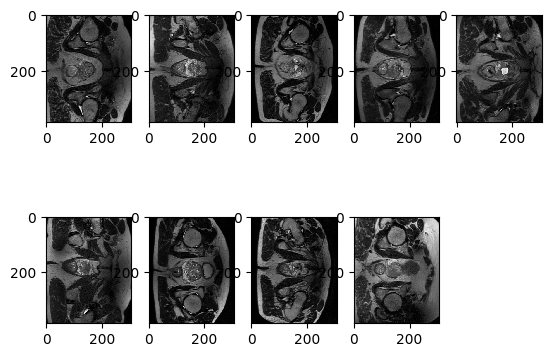

In [4]:
#empty lists to fill with data:
dce = []
t2 = []
adc = []
dwi = []
mask_prost = []
mask_guz = []
for patient in os.listdir(data_path):
    print("I am in the folder %s"%patient)
    for image in os.listdir(data_path+'/'+patient):
        # print("Patient files %s:"%patient, image)
        if 'adc' in image and 'resampled' in image:
            adc.append(nib.load(data_path+'/'+patient+'/'+image).get_fdata())
        elif 'epi' in image and 'resampled' in image:
            dwi.append(nib.load(data_path+'/'+patient+'/'+image).get_fdata())
        elif 't2' in image:
            t2.append(nib.load(data_path+'/'+patient+'/'+image).get_fdata())
        elif 't1' in image and 'resampled' in image:
            dce.append(nib.load(data_path+'/'+patient+'/'+image).get_fdata())
        elif 'cap' in image:
            mask_guz.append(nib.load(data_path+'/'+patient+'/'+image).get_fdata())
        elif 'prostate_mask' in image:
            mask_prost.append(nib.load(data_path+'/'+patient+'/'+image).get_fdata())
        else:
            print("Unexpected file!",image)

# It is necessary to crop images, due to the different sizes of T2-dependent images
# we assume that the images have the same spatial resolution (e.g., 1mmx1mmx1mm)
# In the case of different resolutions, interpolation should be made so that each patient
# had the same resolution of images.

rows = []
cols = []
for patient in t2:
  rows.append(patient.shape[0])
  cols.append(patient.shape[1])



scol = min(cols)
srow = min(rows)
print("Dimensions target images up to %d and %d voxels"%(min(rows), min(cols)))
# Target dimensions of images up to 384 x 308 voxels

for i, patient in enumerate(t2):
    print (i, patient.shape[0])
    col_slice = slice (0, None)
    row_slice = slice (0, None)

    row = patient.shape[0]
    col = patient.shape[1]
    do_cut_row = row-srow
    do_cut_col = col-scol
    if do_cut_col > 0 and do_cut_col% 2 == 0:
        col_slice = slice (do_cut_col//2,-do_cut_col//2)
    elif do_cut_col > 0 and do_cut_col% 2 == 1:
        col_slice = slice (do_cut_col // 2 + 1, -do_cut_col // 2)

    if do_cut_row > 0 and do_cut_row% 2 == 0:
        row_slice = slice (do_cut_row // 2, -do_cut_row // 2)
    elif do_cut_row > 0 and do_cut_row% 2 == 1:
        row_slice = slice (do_cut_row // 2 + 1,-do_cut_row // 2)

    patient_crop = patient [row_slice, col_slice, ...]
    t2[i] = patient_crop

    adc[i] = adc[i][row_slice, col_slice,...]
    dce[i] = dce[i][row_slice, col_slice,...]
    dwi[i] = dwi[i][row_slice, col_slice,...]


# we check the result
plt.figure()
for i,image in enumerate(t2):
    plt.subplot(2,5,i+1)
    plt.imshow(image[:,:, 32], cmap = 'gray', interpolation = 'none', vmin = 0)
